### Importing Necessary Dependencies and Libraries

In [1]:
import pandas as pd
from sklearn.datasets import make_regression
from keras.models import Sequential
from keras.layers import Dense
import shap
import ipywidgets as widgets
import seaborn as sns
import xgboost

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from numpy import linalg as la
from sklearn import tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRFRegressor
import tensorflow as tf
import matplotlib.pyplot as plt
import graphviz 
import time

shap.initjs()
%matplotlib inline

### Importing Dataset

In [2]:
dataset = pd.read_csv('old-CSV-files/lookup-table.csv')
data_test = pd.read_csv('old-CSV-files/lookup-table-test.csv')
X = dataset[['P']]
y = dataset[['phi', 'd1', 'd2']]
X_test2 = data_test[['P']]
y_test2 = data_test[['phi', 'd1', 'd2']]
print('Features size:', X.shape, 'Output size: ', y.shape)
dataset.head(5)

Features size: (351, 1) Output size:  (351, 3)


,P,phi,d1,d2
0,30000,0.187481,0,0.659734
1,30200,0.188746,0,0.659734
2,30400,0.190011,0,0.659734
3,30600,0.191276,0,0.659734
4,30800,0.192542,0,0.659734


### Data Cleaning

In [3]:
# Checking number of NA in the dataset
dataset.isna().sum()

P      0
phi    0
d1     0
d2     0
dtype: int64

In [4]:
# Droping the rows with NA values
dataset_updated = dataset.copy()
dataset_updated = dataset_updated.dropna()
print('Updated Dataset size:', dataset_updated.shape)
dataset_updated.isna().sum()

Updated Dataset size: (351, 4)


P      0
phi    0
d1     0
d2     0
dtype: int64

### Splitting dataset into training and testing set

In [5]:
TRAIN_FRAC = 1.0
break_row = int(TRAIN_FRAC*X.shape[0])
X_train = X.iloc[:break_row,:]
X_test = X.iloc[break_row+1:,:]

y_train = y.iloc[:break_row,:]
y_test  = y.iloc[break_row+1:,:]

print('Trainf features:', X_train.shape, 'Train labels: ', y_train.shape)
print('Test features:', X_test.shape, 'Test labels: ', y_test.shape)

Trainf features: (351, 1) Train labels:  (351, 3)
Test features: (0, 1) Test labels:  (0, 3)


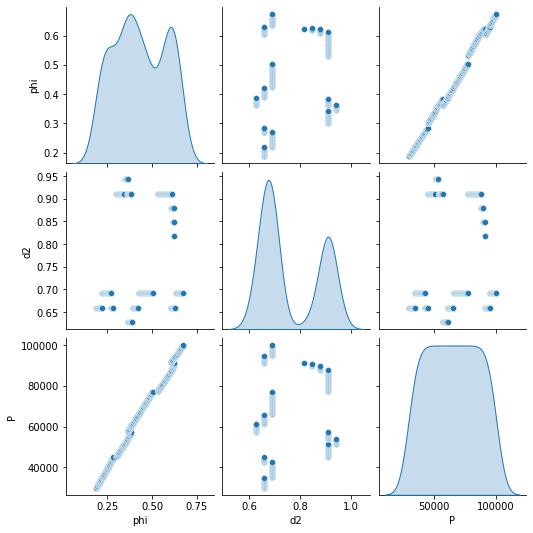

In [6]:
### Review joint distribution of the pair of columns
sns_plot = sns.pairplot(dataset[['phi', 'd2', 'P']], diag_kind='kde')
sns_plot.savefig('images/joint_distribution_plot.pdf', dpi=300)

In [7]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
P,351.0,65000.000000,20293.841430,30000.000000,47500.000000,65000.000000,82500.000000,100000.000000
phi,351.0,0.430292,0.143832,0.187481,0.316141,0.415703,0.570421,0.674770
d1,351.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
d2,351.0,0.761322,0.114864,0.628319,0.659734,0.691150,0.911062,0.942478


# Decision Tree Regression

In [8]:
%%time
# define model with the default hyperparameters
DT_model = DecisionTreeRegressor()

# fit model
DT_model.fit(X_train, y_train)

CPU times: user 3.39 ms, sys: 0 ns, total: 3.39 ms
Wall time: 3.15 ms


DecisionTreeRegressor()

In [9]:
print('Depth of decision tree: ', DT_model.get_depth())
print('No. of leaves: ', DT_model.get_n_leaves())

Depth of decision tree:  11
No. of leaves:  351


### Model Evaluation - Test Data

In [10]:
%%time
# Predicting over test dataset
y_pred = DT_model.predict(X_test2)

CPU times: user 960 µs, sys: 291 µs, total: 1.25 ms
Wall time: 1.17 ms


In [11]:
y_true = y_test2

# Model Performance Metrics
score = explained_variance_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
rmse = mean_squared_error(y_true, y_pred, squared=False)
R2_score = r2_score(y_true, y_pred)

# My Method to average out the error
y_diff = y_true - y_pred
myRMSE = 1/y_diff.shape[0] * np.sqrt(np.dot(y_diff.T, y_diff).diagonal())
avgError = np.mean(myRMSE)

# Displaying the results
print('Score: {:.2f}%'.format(score*100))
print('MSE: ', rmse)
print('Average Error: ', avgError)

Score: 33.33%
MSE:  0.0948193141076158
Average Error:  0.01060112159622669


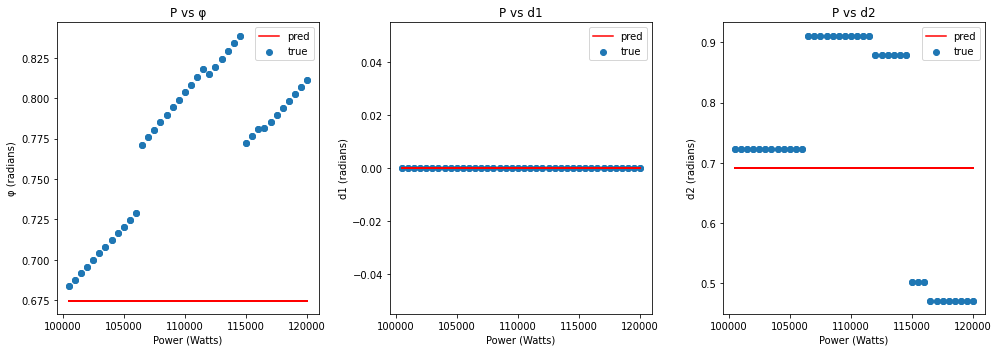

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=False)

# Power vs phi
ax0.set_title('P vs φ')
ax0.scatter(X_test2, y_true['phi'], label='true')
ax0.plot(X_test2, y_pred[:,0], label='pred', color='red')
ax0.set_xlabel('Power (Watts)')
ax0.set_ylabel('φ (radians)')
ax0.legend(loc="upper right")

# Power vs d1
ax1.set_title('P vs d1')
ax1.scatter(X_test2, y_true['d1'], label='true')
ax1.plot(X_test2, y_pred[:,1], label='pred', color='red')
ax1.set_xlabel('Power (Watts)')
ax1.set_ylabel('d1 (radians)')
ax1.legend(loc="upper right")
# ax1.set_ylim([0,0.1])

# Power vs d2
ax2.set_title('P vs d2')
ax2.scatter(X_test2, y_true['d2'], label='true')
ax2.plot(X_test2, y_pred[:,2], label='pred', color='red')
ax2.set_xlabel('Power (Watts)')
ax2.set_ylabel('d2 (radians)')
ax2.legend(loc="upper right")

fig.tight_layout()

fig.savefig('images/decision_tree_test.pdf', dpi=300)
plt.show()

### Model Evaluation on Training Data

In [13]:
# Predicting over test dataset
y_pred = DT_model.predict(X_train)
y_true = y_train

# Model Performance Metrics
score = explained_variance_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
rmse = mean_squared_error(y_true, y_pred, squared=False)
R2_score = r2_score(y_true, y_pred)

# My Method to average out the error
y_diff = y_true - y_pred
myRMSE = 1/y_diff.shape[0] * np.sqrt(np.dot(y_diff.T, y_diff).diagonal())
avgError = np.mean(myRMSE)

# Displaying the results
print('Score: {:.2f}%'.format(score*100))
print('MSE: ', rmse)
print('Average Error: ', avgError)

Score: 100.00%
MSE:  0.0
Average Error:  0.0


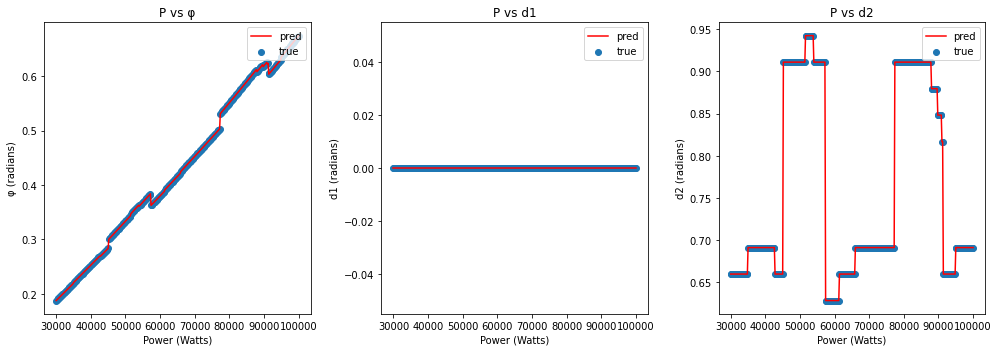

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=False)

# Power vs phi
ax0.set_title('P vs φ')
ax0.scatter(X_train, y_true['phi'], label='true')
ax0.plot(X_train, y_pred[:,0], label='pred', color='red')
ax0.set_xlabel('Power (Watts)')
ax0.set_ylabel('φ (radians)')
ax0.legend(loc="upper right")

# Power vs d1
ax1.set_title('P vs d1')
ax1.scatter(X_train, y_true['d1'], label='true')
ax1.plot(X_train, y_pred[:,1], label='pred', color='red')
ax1.set_xlabel('Power (Watts)')
ax1.set_ylabel('d1 (radians)')
ax1.legend(loc="upper right")
# ax1.set_ylim([0,0.1])

# Power vs d2
ax2.set_title('P vs d2')
ax2.scatter(X_train, y_true['d2'], label='true')
ax2.plot(X_train, y_pred[:,2], label='pred', color='red')
ax2.set_xlabel('Power (Watts)')
ax2.set_ylabel('d2 (radians)')
ax2.legend(loc="upper right")

fig.tight_layout()

fig.savefig('images/decision_tree_train.pdf', dpi=300)
plt.show()

# Random Forest Regression

In [15]:
%%time
# Considering the default model hypterparameters
RF_model = RandomForestRegressor(random_state=0)
RF_model.fit(X_train, y_train)

CPU times: user 85.3 ms, sys: 4.36 ms, total: 89.7 ms
Wall time: 87.5 ms


RandomForestRegressor(random_state=0)

### Model Evaluation - Test data

In [16]:
%%time
# Predicting over test dataset
y_pred = RF_model.predict(X_test2)

CPU times: user 7.04 ms, sys: 868 µs, total: 7.91 ms
Wall time: 6.59 ms


In [17]:
y_true = y_test2

# Model Performance Metrics
score = explained_variance_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
rmse = mean_squared_error(y_true, y_pred, squared=False)
R2_score = r2_score(y_true, y_pred)

# My Method to average out the error
y_diff = y_true - y_pred
myRMSE = 1/y_diff.shape[0] * np.sqrt(np.dot(y_diff.T, y_diff).diagonal())
avgError = np.mean(myRMSE)

# Displaying the results
print('Score: {:.2f}%'.format(score*100))
print('MSE: ', rmse)
print('Average Error: ', avgError)

Score: 33.33%
MSE:  0.0951173825341195
Average Error:  0.01063444665940712


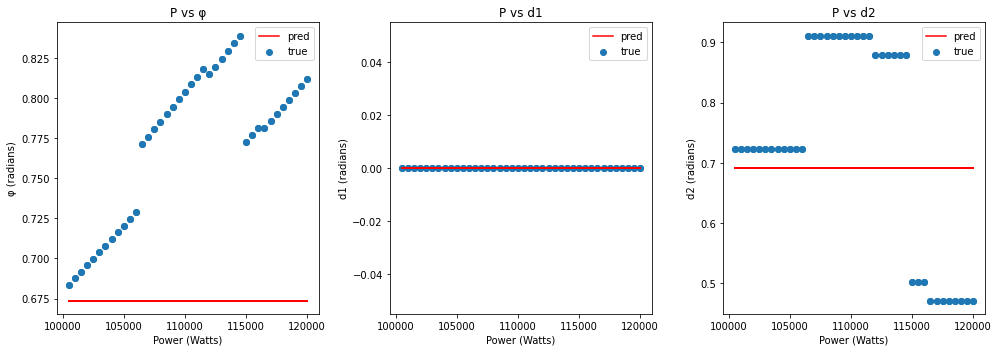

In [18]:
# Predicting over test dataset
test_pred = y_pred
test_true = y_test2

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=False)

# Power vs phi
ax0.set_title('P vs φ')
ax0.scatter(X_test2, test_true['phi'], label='true')
ax0.plot(X_test2, test_pred[:,0], label='pred', color='red')
ax0.set_xlabel('Power (Watts)')
ax0.set_ylabel('φ (radians)')
ax0.legend(loc="upper right")

# Power vs d1
ax1.set_title('P vs d1')
ax1.scatter(X_test2, test_true['d1'], label='true')
ax1.plot(X_test2, test_pred[:,1], label='pred', color='red')
ax1.set_xlabel('Power (Watts)')
ax1.set_ylabel('d1 (radians)')
ax1.legend(loc="upper right")
# ax1.set_ylim([0,0.1])

# Power vs d2
ax2.set_title('P vs d2')
ax2.scatter(X_test2, test_true['d2'], label='true')
ax2.plot(X_test2, test_pred[:,2], label='pred', color='red')
ax2.set_xlabel('Power (Watts)')
ax2.set_ylabel('d2 (radians)')
ax2.legend(loc="upper right")

fig.tight_layout()
fig.savefig('images/random_forest_test.pdf', dpi=300)
plt.show()

### Model Evaluation - Training data

In [19]:
# Predicting over test dataset
y_pred = RF_model.predict(X_train)
y_true = y_train

# Model Performance Metrics
score = explained_variance_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
rmse = mean_squared_error(y_true, y_pred, squared=False)
R2_score = r2_score(y_true, y_pred)

# My Method to average out the error
y_diff = y_true - y_pred
myRMSE = 1/y_diff.shape[0] * np.sqrt(np.dot(y_diff.T, y_diff).diagonal())
avgError = np.mean(myRMSE)

# Displaying the results
print('Score: {:.2f}%'.format(score*100))
print('MSE: ', rmse)
print('Average Error: ', avgError)

Score: 99.87%
MSE:  0.002642730386763567
Average Error:  0.00014105851261235128


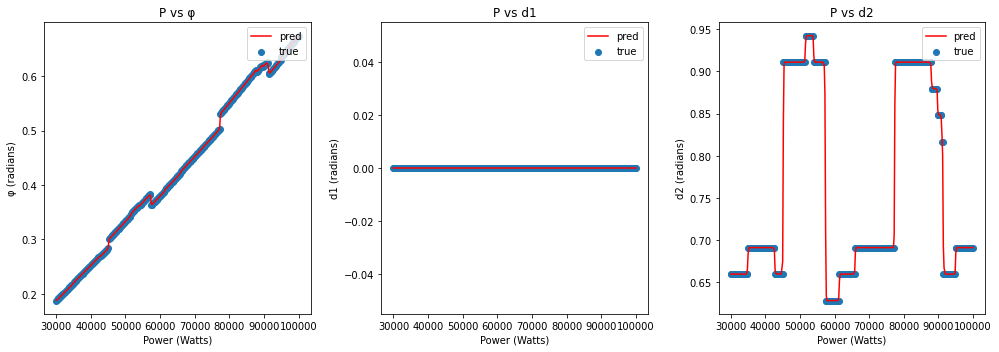

In [20]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=False)

# Power vs phi
ax0.set_title('P vs φ')
ax0.scatter(X_train, y_true['phi'], label='true')
ax0.plot(X_train, y_pred[:,0], label='pred', color='red')
ax0.set_xlabel('Power (Watts)')
ax0.set_ylabel('φ (radians)')
ax0.legend(loc="upper right")

# Power vs d1
ax1.set_title('P vs d1')
ax1.scatter(X_train, y_true['d1'], label='true')
ax1.plot(X_train, y_pred[:,1], label='pred', color='red')
ax1.set_xlabel('Power (Watts)')
ax1.set_ylabel('d1 (radians)')
ax1.legend(loc="upper right")
# ax1.set_ylim([0,0.1])

# Power vs d2
ax2.set_title('P vs d2')
ax2.scatter(X_train, y_true['d2'], label='true')
ax2.plot(X_train, y_pred[:,2], label='pred', color='red')
ax2.set_xlabel('Power (Watts)')
ax2.set_ylabel('d2 (radians)')
ax2.legend(loc="upper right")

fig.tight_layout()

fig.savefig('images/random_forest_train.pdf', dpi=300)
plt.show()

# Linear Regression

In [21]:
%%time

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

CPU times: user 2.48 ms, sys: 0 ns, total: 2.48 ms
Wall time: 2.34 ms


LinearRegression()

### Model Evaluation - Test data

In [22]:
%%time
# Predicting over test dataset
y_pred = LR_model.predict(X_test2)

CPU times: user 752 µs, sys: 210 µs, total: 962 µs
Wall time: 944 µs


In [23]:
y_true = y_test2

# Model Performance Metrics
score = explained_variance_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
rmse = mean_squared_error(y_true, y_pred, squared=False)
R2_score = r2_score(y_true, y_pred)

# My Method to average out the error
y_diff = y_true - y_pred
myRMSE = 1/y_diff.shape[0] * np.sqrt(np.dot(y_diff.T, y_diff).diagonal())
avgError = np.mean(myRMSE)

# Displaying the results
print('Score: {:.2f}%'.format(score*100))
print('MSE: ', rmse)
print('Average Error: ', avgError)

Score: 53.31%
MSE:  0.07405657319169157
Average Error:  0.008279776591865545


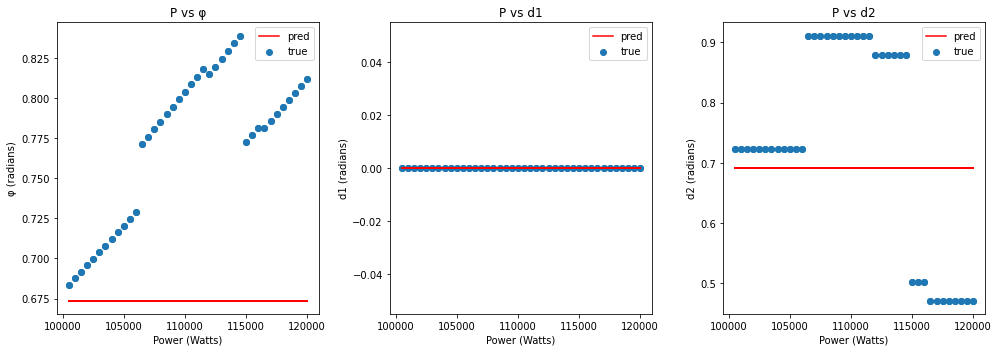

In [24]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=False)

# Power vs phi
ax0.set_title('P vs φ')
ax0.scatter(X_test2, test_true['phi'], label='true')
ax0.plot(X_test2, test_pred[:,0], label='pred', color='red')
ax0.set_xlabel('Power (Watts)')
ax0.set_ylabel('φ (radians)')
ax0.legend(loc="upper right")

# Power vs d1
ax1.set_title('P vs d1')
ax1.scatter(X_test2, test_true['d1'], label='true')
ax1.plot(X_test2, test_pred[:,1], label='pred', color='red')
ax1.set_xlabel('Power (Watts)')
ax1.set_ylabel('d1 (radians)')
ax1.legend(loc="upper right")
# ax1.set_ylim([0,0.1])

# Power vs d2
ax2.set_title('P vs d2')
ax2.scatter(X_test2, test_true['d2'], label='true')
ax2.plot(X_test2, test_pred[:,2], label='pred', color='red')
ax2.set_xlabel('Power (Watts)')
ax2.set_ylabel('d2 (radians)')
ax2.legend(loc="upper right")

fig.tight_layout()
fig.savefig('images/linear_regression_test.pdf', dpi=300)
plt.show()

### Model Evaluation - Training data

In [25]:
# Predicting over test dataset
y_pred = LR_model.predict(X_train)
y_true = y_train

# Model Performance Metrics
score = explained_variance_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
rmse = mean_squared_error(y_true, y_pred, squared=False)
R2_score = r2_score(y_true, y_pred)

# My Method to average out the error
y_diff = y_true - y_pred
myRMSE = 1/y_diff.shape[0] * np.sqrt(np.dot(y_diff.T, y_diff).diagonal())
avgError = np.mean(myRMSE)

# Displaying the results
print('Score: {:.2f}%'.format(score*100))
print('MSE: ', rmse)
print('Average Error: ', avgError)

Score: 67.08%
MSE:  0.04172537918345522
Average Error:  0.0022271359784879663


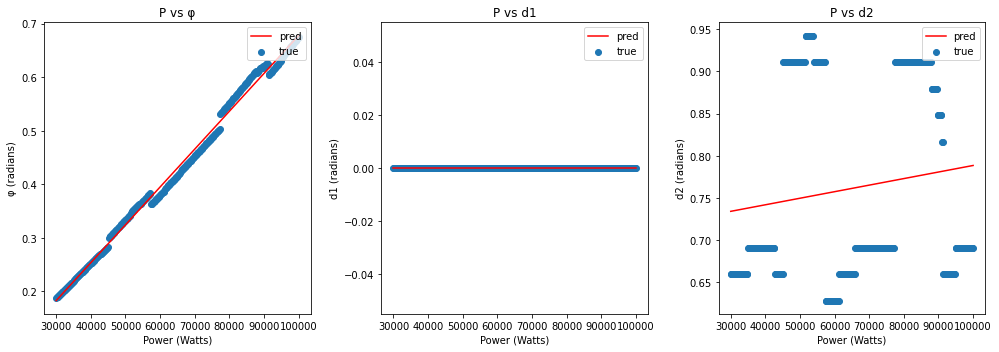

In [26]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=False)

# Power vs phi
ax0.set_title('P vs φ')
ax0.scatter(X_train, y_true['phi'], label='true')
ax0.plot(X_train, y_pred[:,0], label='pred', color='red')
ax0.set_xlabel('Power (Watts)')
ax0.set_ylabel('φ (radians)')
ax0.legend(loc="upper right")

# Power vs d1
ax1.set_title('P vs d1')
ax1.scatter(X_train, y_true['d1'], label='true')
ax1.plot(X_train, y_pred[:,1], label='pred', color='red')
ax1.set_xlabel('Power (Watts)')
ax1.set_ylabel('d1 (radians)')
ax1.legend(loc="upper right")
# ax1.set_ylim([0,0.1])

# Power vs d2
ax2.set_title('P vs d2')
ax2.scatter(X_train, y_true['d2'], label='true')
ax2.plot(X_train, y_pred[:,2], label='pred', color='red')
ax2.set_xlabel('Power (Watts)')
ax2.set_ylabel('d2 (radians)')
ax2.legend(loc="upper right")

fig.tight_layout()

fig.savefig('images/linear_regression_train.pdf', dpi=300)
plt.show()

# k-Nearest Neighbors

In [27]:
%%time

kNN_model = KNeighborsRegressor()
kNN_model.fit(X_train, y_train)

CPU times: user 2.86 ms, sys: 0 ns, total: 2.86 ms
Wall time: 2.55 ms


KNeighborsRegressor()

### Model Evaluation - Test data

In [28]:
%%time
# Predicting over test dataset
y_pred = kNN_model.predict(X_test2)

CPU times: user 2.27 ms, sys: 0 ns, total: 2.27 ms
Wall time: 2.03 ms


In [29]:
y_true = y_test2

# Model Performance Metrics
score = explained_variance_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
rmse = mean_squared_error(y_true, y_pred, squared=False)
R2_score = r2_score(y_true, y_pred)

# My Method to average out the error
y_diff = y_true - y_pred
myRMSE = 1/y_diff.shape[0] * np.sqrt(np.dot(y_diff.T, y_diff).diagonal())
avgError = np.mean(myRMSE)

# Displaying the results
print('Score: {:.2f}%'.format(score*100))
print('MSE: ', rmse)
print('Average Error: ', avgError)

Score: 33.33%
MSE:  0.09578227933847772
Average Error:  0.01070878438203549


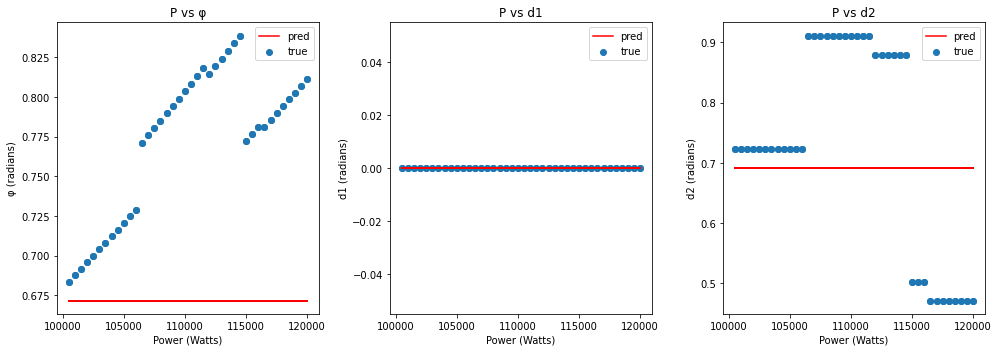

In [30]:
# Predicting over test dataset
test_pred = kNN_model.predict(X_test2)
test_true = y_test2

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=False)

# Power vs phi
ax0.set_title('P vs φ')
ax0.scatter(X_test2, test_true['phi'], label='true')
ax0.plot(X_test2, test_pred[:,0], label='pred', color='red')
ax0.set_xlabel('Power (Watts)')
ax0.set_ylabel('φ (radians)')
ax0.legend(loc="upper right")

# Power vs d1
ax1.set_title('P vs d1')
ax1.scatter(X_test2, test_true['d1'], label='true')
ax1.plot(X_test2, test_pred[:,1], label='pred', color='red')
ax1.set_xlabel('Power (Watts)')
ax1.set_ylabel('d1 (radians)')
ax1.legend(loc="upper right")
# ax1.set_ylim([0,0.1])

# Power vs d2
ax2.set_title('P vs d2')
ax2.scatter(X_test2, test_true['d2'], label='true')
ax2.plot(X_test2, test_pred[:,2], label='pred', color='red')
ax2.set_xlabel('Power (Watts)')
ax2.set_ylabel('d2 (radians)')
ax2.legend(loc="upper right")

fig.tight_layout()
fig.savefig('images/kNN_test.pdf', dpi=300)
plt.show()

### Model Evaluation - Train data

In [31]:
# Predicting over test dataset
y_pred = kNN_model.predict(X_train)
y_true = y_train

# Model Performance Metrics
score = explained_variance_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
rmse = mean_squared_error(y_true, y_pred, squared=False)
R2_score = r2_score(y_true, y_pred)

# My Method to average out the error
y_diff = y_true - y_pred
myRMSE = 1/y_diff.shape[0] * np.sqrt(np.dot(y_diff.T, y_diff).diagonal())
avgError = np.mean(myRMSE)

# Displaying the results
print('Score: {:.2f}%'.format(score*100))
print('MSE: ', rmse)
print('Average Error: ', avgError)

Score: 99.36%
MSE:  0.005806526910555495
Average Error:  0.00030992947806893586


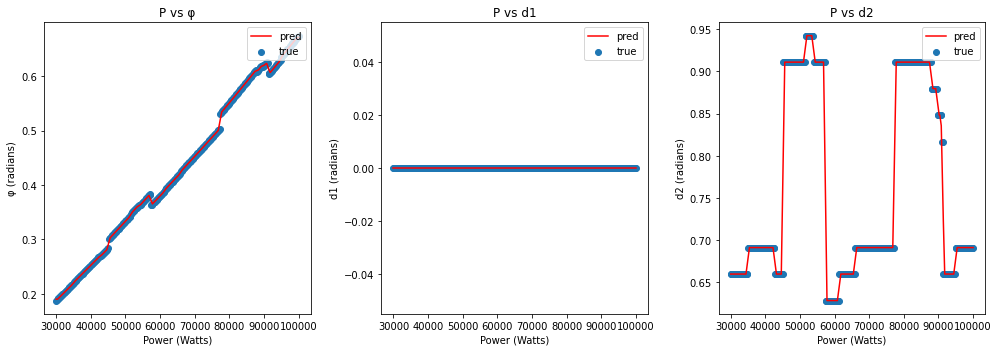

In [32]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=False)

# Power vs phi
ax0.set_title('P vs φ')
ax0.scatter(X_train, y_true['phi'], label='true')
ax0.plot(X_train, y_pred[:,0], label='pred', color='red')
ax0.set_xlabel('Power (Watts)')
ax0.set_ylabel('φ (radians)')
ax0.legend(loc="upper right")

# Power vs d1
ax1.set_title('P vs d1')
ax1.scatter(X_train, y_true['d1'], label='true')
ax1.plot(X_train, y_pred[:,1], label='pred', color='red')
ax1.set_xlabel('Power (Watts)')
ax1.set_ylabel('d1 (radians)')
ax1.legend(loc="upper right")
# ax1.set_ylim([0,0.1])

# Power vs d2
ax2.set_title('P vs d2')
ax2.scatter(X_train, y_true['d2'], label='true')
ax2.plot(X_train, y_pred[:,2], label='pred', color='red')
ax2.set_xlabel('Power (Watts)')
ax2.set_ylabel('d2 (radians)')
ax2.legend(loc="upper right")

fig.tight_layout()

fig.savefig('images/kNN_train.pdf', dpi=300)
plt.show()

# MultiOutput Regression using Sklearn

### Defining Model Architecture and Training

In [33]:
MOR_model = MultiOutputRegressor(Ridge(random_state=123))
MOR_model.fit(X_train, y_train)

score = MOR_model.score(X_test2, y_test2)
print('Model Accuracy: {:.2f}%'.format(score*100))

Model Accuracy: 41.15%


### Model Evaluation

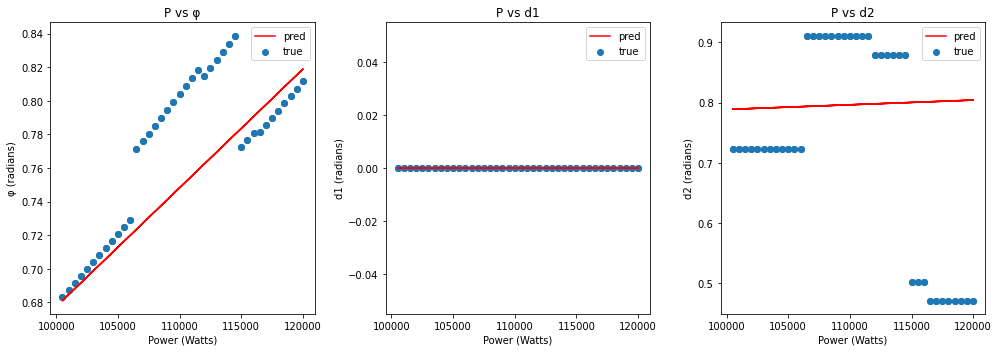

In [34]:
# Predicting over test dataset
test_pred = MOR_model.predict(X_test2)
test_true = y_test2

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=False)

# Power vs phi
ax0.set_title('P vs φ')
ax0.scatter(X_test2, test_true['phi'], label='true')
ax0.plot(X_test2, test_pred[:,0], label='pred', color='red')
ax0.set_xlabel('Power (Watts)')
ax0.set_ylabel('φ (radians)')
ax0.legend(loc="upper right")

# Power vs d1
ax1.set_title('P vs d1')
ax1.scatter(X_test2, test_true['d1'], label='true')
ax1.plot(X_test2, test_pred[:,1], label='pred', color='red')
ax1.set_xlabel('Power (Watts)')
ax1.set_ylabel('d1 (radians)')
ax1.legend(loc="upper right")
# ax1.set_ylim([0,0.1])

# Power vs d2
ax2.set_title('P vs d2')
ax2.scatter(X_test2, test_true['d2'], label='true')
ax2.plot(X_test2, test_pred[:,2], label='pred', color='red')
ax2.set_xlabel('Power (Watts)')
ax2.set_ylabel('d2 (radians)')
ax2.legend(loc="upper right")

fig.tight_layout()
fig.savefig('images/MLP.pdf', dpi=300)
plt.show()

# Feedforward Neural Network

### Model Architecture Declaration

In [35]:
def build_and_compile_model(normalized_layer):
    model = tf.keras.Sequential([
        normalized_layer,
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1])
    ])
    
    # Model compilation
    model.compile(loss='mean_absolute_error',
                 optimizer=tf.optimizers.Adam(learning_rate=0.001))
    return model

def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Model Output (y)')
    plt.legend()
    plt.grid(True)
    plt.savefig('images/train_history.svg', dpi=300)

### Defining Normalization Layer for Input Data

In [36]:
%%time
### Create Normalization layer for the model
normalized_features = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
normalized_features.adapt(np.array(X_train))

CPU times: user 174 ms, sys: 46.4 ms, total: 220 ms
Wall time: 243 ms


### Model Architecture

In [37]:
%%time
dnn_MIMO = build_and_compile_model(normalized_features)
tf.keras.utils.plot_model(dnn_MIMO, to_file='NN_arch.png', show_shapes=True)
dnn_MIMO.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 512)               66048     
                                                                 
 dense_4 (Dense)             (None, 3)                 1539      
                                                        

### Model Training

In [38]:
%%time
history = dnn_MIMO.fit(X_train,
                      y_train,
                      validation_split=0.25,
                      verbose=0,
                      epochs=200)

CPU times: user 8.1 s, sys: 1.12 s, total: 9.22 s
Wall time: 4.87 s


### Visualization

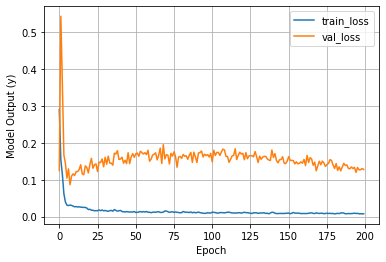

In [39]:
plot_loss(history)

### Model Evaluation - Test data

In [40]:
model_accuracy = dnn_MIMO.evaluate(X_test2,
                                   y_test2, 
                                   verbose=0)
print('Accuracy on Test dataset: {:.2f}%'.format(model_accuracy*100))

Accuracy on Test dataset: 28.77%


In [41]:
%%time
test_pred_raw = dnn_MIMO.predict(X_test2)

CPU times: user 80.9 ms, sys: 0 ns, total: 80.9 ms
Wall time: 74.7 ms


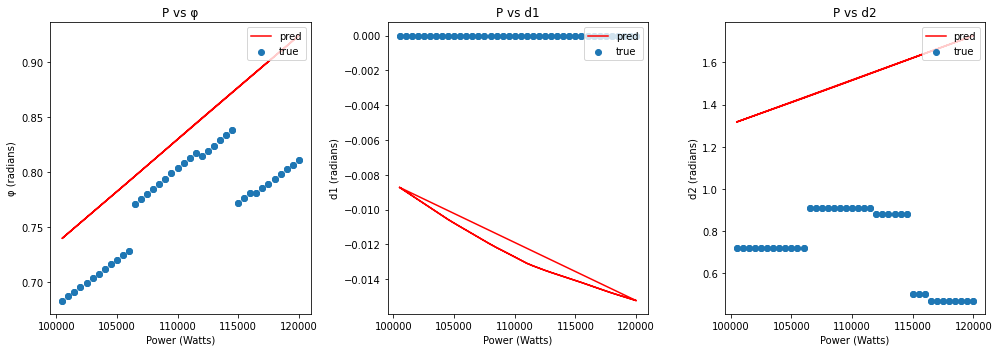

In [42]:
test_pred = test_pred_raw
test_true = y_test2

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=False)

# Power vs phi
ax0.set_title('P vs φ')
ax0.scatter(X_test2, test_true['phi'], label='true')
ax0.plot(X_test2, test_pred[:,0], label='pred', color='red')
ax0.set_xlabel('Power (Watts)')
ax0.set_ylabel('φ (radians)')
ax0.legend(loc="upper right")

# Power vs d1
ax1.set_title('P vs d1')
ax1.scatter(X_test2, test_true['d1'], label='true')
ax1.plot(X_test2, test_pred[:,1], label='pred', color='red')
ax1.set_xlabel('Power (Watts)')
ax1.set_ylabel('d1 (radians)')
ax1.legend(loc="upper right")
# ax1.set_ylim([0,0.1])

# Power vs d2
ax2.set_title('P vs d2')
ax2.scatter(X_test2, test_true['d2'], label='true')
ax2.plot(X_test2, test_pred[:,2], label='pred', color='red')
ax2.set_xlabel('Power (Watts)')
ax2.set_ylabel('d2 (radians)')
ax2.legend(loc="upper right")

fig.tight_layout()
fig.savefig('images/neural_network_test.pdf', dpi=300)
plt.show()

### Model Evaluation - Train data

In [43]:
# Predicting over test dataset
y_pred = dnn_MIMO.predict(X_train)
y_true = y_train

# Model Performance Metrics
score = abs(explained_variance_score(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
rmse = mean_squared_error(y_true, y_pred, squared=False)
R2_score = r2_score(y_true, y_pred)

# My Method to average out the error
y_diff = y_true - y_pred
myRMSE = 1/y_diff.shape[0] * np.sqrt(np.dot(y_diff.T, y_diff).diagonal())
avgError = np.mean(myRMSE)

# Displaying the results
print('Score: {:.2f}%'.format(score*100))
print('MSE: ', rmse)
print('Average Error: ', avgError)

Score: 17.27%
MSE:  0.075760909331808
Average Error:  0.0040438181806323375


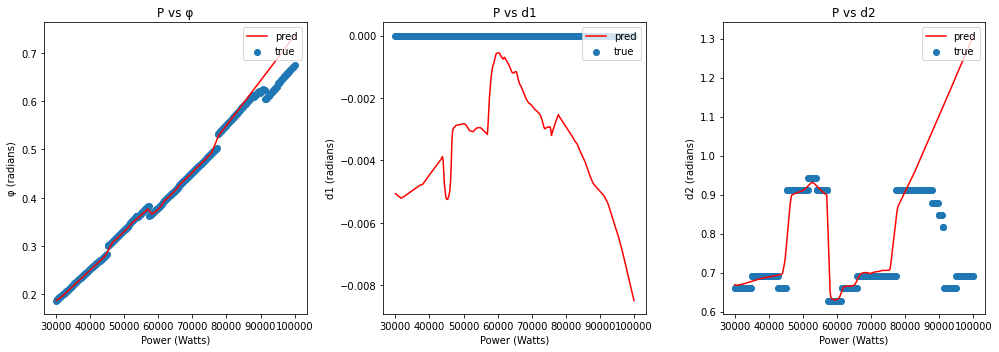

In [44]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=False)

# Power vs phi
ax0.set_title('P vs φ')
ax0.scatter(X_train, y_true['phi'], label='true')
ax0.plot(X_train, y_pred[:,0], label='pred', color='red')
ax0.set_xlabel('Power (Watts)')
ax0.set_ylabel('φ (radians)')
ax0.legend(loc="upper right")

# Power vs d1
ax1.set_title('P vs d1')
ax1.scatter(X_train, y_true['d1'], label='true')
ax1.plot(X_train, y_pred[:,1], label='pred', color='red')
ax1.set_xlabel('Power (Watts)')
ax1.set_ylabel('d1 (radians)')
ax1.legend(loc="upper right")
# ax1.set_ylim([0,0.1])

# Power vs d2
ax2.set_title('P vs d2')
ax2.scatter(X_train, y_true['d2'], label='true')
ax2.plot(X_train, y_pred[:,2], label='pred', color='red')
ax2.set_xlabel('Power (Watts)')
ax2.set_ylabel('d2 (radians)')
ax2.legend(loc="upper right")

fig.tight_layout()

fig.savefig('images/neural_network_train.pdf', dpi=300)
plt.show()

### Save the Model

In [45]:
dnn_MIMO.save('models/dnn_MIMO')

INFO:tensorflow:Assets written to: models/dnn_MIMO/assets


# Model Performance Explanations (SHAP)

In [46]:
# Small sample of dataset for model explanation
X = X_test2
explainer = shap.KernelExplainer(model = dnn_MIMO.predict, data = X.head(50), link = "identity")

# Get the Shapley value for a single example
X_idx = 0

# Create the list of all labels for the drop down list
list_of_labels = y.columns.to_list()
shap_value_single = explainer.shap_values(X = X.iloc[X_idx:X_idx+1,:], nsamples = 100)

### Force Plot for a single input and single output variable (SISO)

In [47]:
print(f'Current label Shown: {list_of_labels[0]}')

shap.force_plot(base_value = explainer.expected_value[0],
                shap_values = shap_value_single[0], 
                features = X.iloc[X_idx:X_idx+1,:]
                )

Current label Shown: phi


In [48]:
print(f'Current label Shown: {list_of_labels[1]}')

shap.force_plot(base_value = explainer.expected_value[1],
                shap_values = shap_value_single[1], 
                features = X.iloc[X_idx:X_idx+1,:]
                )

Current label Shown: d1


In [49]:
print(f'Current label Shown: {list_of_labels[2]}')

shap.force_plot(base_value = explainer.expected_value[2],
                shap_values = shap_value_single[2], 
                features = X.iloc[X_idx:X_idx+1,:]
                )

Current label Shown: d2


### Summary Plot for all Inputs impact on the output variable


Current Label Shown: phi



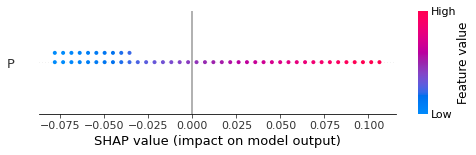


Current Label Shown: d1



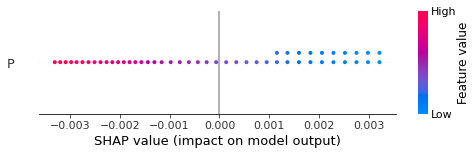


Current Label Shown: d2



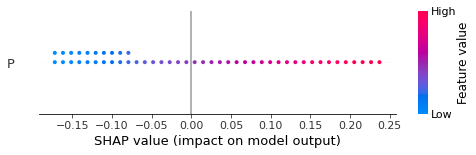

In [50]:
for idx in range(y_test2.shape[1]):
    shap_values = explainer.shap_values(X = X.iloc[0:50,:], nsamples = 100)

    print(f'Current Label Shown: {list_of_labels[idx]}\n')
    shap.summary_plot(shap_values = shap_values[idx],
                      features = X.iloc[0:50,:]
                      ) 

### Force Plot for the first 50 individual examples

In [51]:
print(f'Current Label Shown: {list_of_labels[0]}\n')

shap.force_plot(base_value = explainer.expected_value[0],
                shap_values = shap_values[0], 
                features = X.iloc[0:50,:]
                )

Current Label Shown: phi



In [52]:
print(f'Current Label Shown: {list_of_labels[1]}\n')

shap.force_plot(base_value = explainer.expected_value[1],
                shap_values = shap_values[1], 
                features = X.iloc[0:50,:]
                )

Current Label Shown: d1

